# Step 1: upload structure

# Compute the equation of state with CP2K

**Authors: Aliaksandr Yakutovich (LSMO/THEOS, EPFL)**

This automatic workflow allows to compute an equation of state of a material
It is powered by:
- [CP2K](https://www.cp2k.org/) as the quantum engine
- [AiiDA](http://www.aiida.net) as the automation platform
- [AiiDA-CP2K](https://github.com/aiidateam/aiida-cp2k) plugin

In [1]:
%aiida

Loaded AiiDA DB environment.

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# General imports

%matplotlib notebook
import ipywidgets as ipw
import matplotlib.pyplot as plt
import numpy as np

# AiiDA imports
from aiida.engine import calcfunction, run, WorkChain, ToContext, while_
from aiida.orm import StructureData

# AiiDA lab imports
from aiidalab_widgets_base import CodeDropdown
from aiidalab_widgets_base import viewer, CodeDropdown, CodQueryWidget, ProcessFollowerWidget, ProgressBarWidget, RunningCalcJobOutputWidget
from aiidalab_widgets_base import StructureUploadWidget, StructureBrowserWidget, SubmitButtonWidget

_ColormakerRegistry()

In [4]:
optimized_structure = None
opt_calc_output = ipw.Output(layout={'visibility':'hidden'})
ax = None
fig = None
npoints = 5
Cp2kCalculation = CalculationFactory('cp2k')
eos_calc_message = ipw.HTML()

In [5]:
number_of_nodes = ipw.IntText(
    value=1,
    step=1,
    description = "that will be run on",
    disabled=False,
    layout=ipw.Layout(width="180px"),
    style={"description_width":"120px"},
)

cpus_per_node = ipw.IntText(
    value=1,
    step=1,
    description = "",
    disabled=False,
    layout=ipw.Layout(width="50px"),
    style={"description_width":"0px"},
)


btn_submit_cell = ipw.Button(
    description='Run Cell Opt',
    disabled=False,
)

code_group = CodeDropdown(input_plugin='cp2k', text="Select the code")

submit_out = ipw.Output()

structure_widget = StructureUploadWidget(
    examples=[
        ('Diamond', 'miscellaneous/structures/diamond.cif'),
    ],
    data_importers=[
        ("AiiDA database", StructureBrowserWidget()),
        ("COD", CodQueryWidget()),
    ],
    storable=False,
    node_class='StructureData')

def change_submit_calc_visibility(c):
    submit_out.layout.visibility = 'visible' if c['new'] else 'hidden'

structure_widget.observe(change_submit_calc_visibility, names=['has_structure'])

In [6]:
def get_parameters(run_type, structure):
    params = {
        'GLOBAL': {
            'RUN_TYPE': run_type,
        },
        'FORCE_EVAL': {
            'METHOD': 'Quickstep',
            'STRESS_TENSOR': 'Analytical',
            'DFT': {
                'BASIS_SET_FILE_NAME': 'BASIS_MOLOPT',
                'POTENTIAL_FILE_NAME': 'POTENTIAL',
                'SCF': {
                    'MAX_SCF': 30,
                    'EPS_SCF': 1e-7,
                    'OT': {
                        'PRECONDITIONER': 'FULL_SINGLE_INVERSE',
                        'MINIMIZER': 'DIIS'
                    },
                    'OUTER_SCF': {
                        'MAX_SCF': 4,
                        'EPS_SCF': 1e-7,
                    },
                },
                'QS': {
                    'EPS_DEFAULT': 1.0e-12,
                    'WF_INTERPOLATION': 'ps',
                    'EXTRAPOLATION_ORDER': 3,
                },
                'MGRID': {
                    'NGRIDS': 4,
                    'CUTOFF': 150,
                    'REL_CUTOFF': 20,
                },
                'XC': {
                    'XC_FUNCTIONAL': {
                        '_': 'PBE',
                    },
                },
            },
            'SUBSYS': {
                'KIND': [
                    {
                        '_': e,
                        'BASIS_SET': 'DZVP-MOLOPT-SR-GTH',
                        'POTENTIAL': 'GTH-PBE'
                    } for e in structure.get_kind_names()
                ],
            },
        }
    }
    
    return params

In [7]:
def setup_opt_calc():
    builder = Cp2kCalculation.get_builder()

    if code_group.selected_code is None:
        print ("Please select a code")
        return None

    if structure_widget.structure_node is None:
        print ("Please select a structure")
        return None

    parameters = get_parameters(run_type="CELL_OPT", structure=structure_widget.structure_node)
    options =  {
        'max_wallclock_seconds': 3600*2,
        'resources':{
            'num_machines': number_of_nodes.value,
            'num_mpiprocs_per_machine': cpus_per_node.value,
        }
    }
    
    builder.code = code_group.selected_code
    builder.structure = structure_widget.structure_node
    builder.parameters = Dict(dict=parameters)
    builder.metadata.options = {
        'max_wallclock_seconds': 3600*2,
        'resources':{
            'num_machines': number_of_nodes.value,
            'num_mpiprocs_per_machine': cpus_per_node.value,
        }
    }

    return builder

In [8]:
@calcfunction
def scale_structure(structure, scaling_factor):
    """
    Workfunction to scale a structure

    :param structure: An AiiDA structure to scale
    :param scaling_factor: The scaling factor
    :return: The scaled StructureData object
    """
    ase_old = structure.get_ase()
    ase_new = ase_old.copy()
    ase_new.set_cell(ase_old.get_cell() * float(scaling_factor), scale_atoms=True)
    structure = StructureData(ase=ase_new)

    return structure

class EquationOfState(WorkChain):
    """Workchain that for a given structure will compute the equation of state by
    computing the total energy for a set of derived structures with a scaled
    lattice parameter."""

    @classmethod
    def define(cls, spec):
        super(EquationOfState, cls).define(spec)
        
        # First we define the inputs, specifying the type we expect
        spec.input("structure", valid_type=StructureData)
        spec.input("code", valid_type=Code)
        spec.input("npoints", valid_type=Int)
        
        # The outline describes the business logic that defines
        # which steps are executed in what order and based on
        # what conditions. Each `cls.method` is implemented below
        spec.outline(
            cls.init,
            while_(cls.should_run_cp2k)(
                cls.run_cp2k,
                cls.parse_cp2k,
            ),
            cls.return_result,
        )
        
        # Here we define the output the Workchain will generate and
        # return. Dynamic output allows a variety of AiiDA data nodes
        # to be returned
        spec.outputs.dynamic = True

    def init(self):
        """
        Initialize variables and the scales we want to compute
        """
        npoints = self.inputs.npoints.value
        self.ctx.i = 0
        self.ctx.cell_volume = 0.0
        self.ctx.scales = sorted([1 - pow(-1, x)*0.02*int((x+1)/2) for x in range(npoints)])
        self.ctx.result = []
        self.ctx.options = {
            'max_wallclock_seconds': 3600*2,
            'resources':{
                'num_machines': number_of_nodes.value,
                'num_mpiprocs_per_machine': cpus_per_node.value,
            }
        }

        self.ctx.parameters = get_parameters(run_type="ENERGY", structure=optimized_structure)     

    def should_run_cp2k(self):
        """
        This is the main condition of the while loop, as defined
        in the outline of the Workchain. We only run another
        pw.x calculation if the current iteration is smaller than
        the total number of scale factors we want to compute
        """
        return self.ctx.i < len(self.ctx.scales)

    def run_cp2k(self):
        """
        This is the main function that will perform a pw.x
        calculation for the current scaling factor
        """
        scale = self.ctx.scales[self.ctx.i]
        structure = scale_structure(self.inputs.structure, Float(scale))
        self.ctx.i += 1
        self.ctx.cell_volume = structure.get_cell_volume()

        # Create the input dictionary
        inputs = {
            'code'       : self.inputs.code,
            'structure'  : structure,
            'parameters' : ParameterData(dict=self.ctx.parameters),
            '_options'   : self.ctx.options,
        }

        # Create the calculation process and launch it
        self.report("Running pw.x for the scale factor {}".format(scale))
        process = Cp2kCalculation.process()
        future  = submit(process, **inputs)

        return ToContext(pw=Outputs(future))

    def parse_cp2k(self):
        """Extract the volume and total energy of the last completed PwCalculation."""
        volume = self.ctx.cell_volume
        energy = self.ctx.pw["output_parameters"].dict.energy
        self.ctx.result.append((volume, energy))
        
        self.plot_data()

    def return_result(self):
        """Attach the results of the PwCalculations and the initial structure to the outputs."""
        result = {
            "initial_structure": self.inputs.structure,
            "result": ParameterData(dict={"eos": self.ctx.result}),
        }

        for link_name, node in result.iteritems():
            self.out(link_name, node)

        self.report("Workchain <{}> completed successfully".format(self.calc.pk))

        return

    def plot_data(self):
        global ax, fig
        tmpx, tmpy = zip(*self.ctx.result)
        ax.plot(tmpx, tmpy, marker='o', linestyle='--', color='r')
        if self.ctx.i > 4:
            coeff = np.polyfit(tmpx, tmpy, 2)
            eqn = np.poly1d(coeff)
            xnew = np.linspace(tmpx[0], tmpx[-1], num=1001, endpoint=True)
            ax.plot(xnew, eqn(xnew), linestyle='-', color='g')
        fig.canvas.draw()


In [9]:
def setup_eos_calc():
    global ax, fig
    global optimized_structure
    
    # Initialize plot variables
    fig, ax = plt.subplots(1,1)
    garbage = ax.set_xlabel(u"Volume [Å^3]")
    garbage = ax.set_ylabel(u"Total energy [eV]")

    inputs = EquationOfState.get_builder()
    
    inputs.npoints = Int(npoints)
    inputs.structure = optimized_structure
    inputs.code = code_group.selected_code
    
    return inputs

In [10]:
def on_click_submit_eos(change=None):
    global ax, fig
    global optimized_structure, eos_submit

    # Initialize plot variables
    fig, ax = plt.subplots(1,1)
    garbage = ax.set_xlabel(u"Volume [Å^3]")
    garbage = ax.set_ylabel(u"Total energy [eV]")

    eos_calc_message.value = """<h4>Please wait, the Equation of State is being computed
    <i class="fa fa-spinner fa-pulse" style="color:#337ab7;" ></i></h4>
    Final results of the Equation of State workchain:
    """
    fllw = ProcessFollowerWidget(eos_submit.process, followers=[ProgressBarWidget])
    display(fllw)
    fllw.follow()

    print ("{volume:12}  {energy:12}".format(volume="Volume (A^3)", energy="Energy (eV)"))
    print ("{}".format("-"*26))
    for p in outputs["result"].get_dict()['eos']:
        print ("{volume:>12.5f}  {energy:>12.5f}".format(volume=p[0], energy=p[1]))
    eos_calc_message.value = """<h4>The Equation of State is computed
    <i class="fa fa-check " style="color:#337ab7;" ></i></h4>"""

In [11]:
def show_eos_inputs(change=None):
    global optimized_structure, eos_submit
    fllw = ProcessFollowerWidget(opt_submit.process, followers=[ProgressBarWidget, RunningCalcJobOutputWidget])
    display(fllw)
    fllw.follow()
    
    # Get the optimized structure, once the optimization is finished.
    optimized_structure = opt_submit.process.outputs.output_structure

    # Preparing the Equation of State calculation.
    eos_submit = SubmitButtonWidget(process=EquationOfState, widgets_values=setup_eos_calc)
    eos_submit.on_click(on_click_submit_eos)
    display(ipw.HBox([code_group, number_of_nodes, ipw.HTML("node(s)"), cpus_per_node, ipw.HTML("CPU each")]))
    display(eos_submit)
    display(eos_calc_message)

StructureUploadWidget(children=(Tab(children=(VBox(children=(FileUploadWidget(label='Upload Structure', _dom_c…

SubmitButtonWidget(children=(Button(description='Submit', style=ButtonStyle()), Output()))

ProcessFollowerWidget(children=(ProgressBarWidget(children=(IntProgress(value=0, bar_style='info', description…

SubmitButtonWidget(children=(Button(description='Submit', style=ButtonStyle()), Output()))

HTML(value='')

<IPython.core.display.Javascript object>


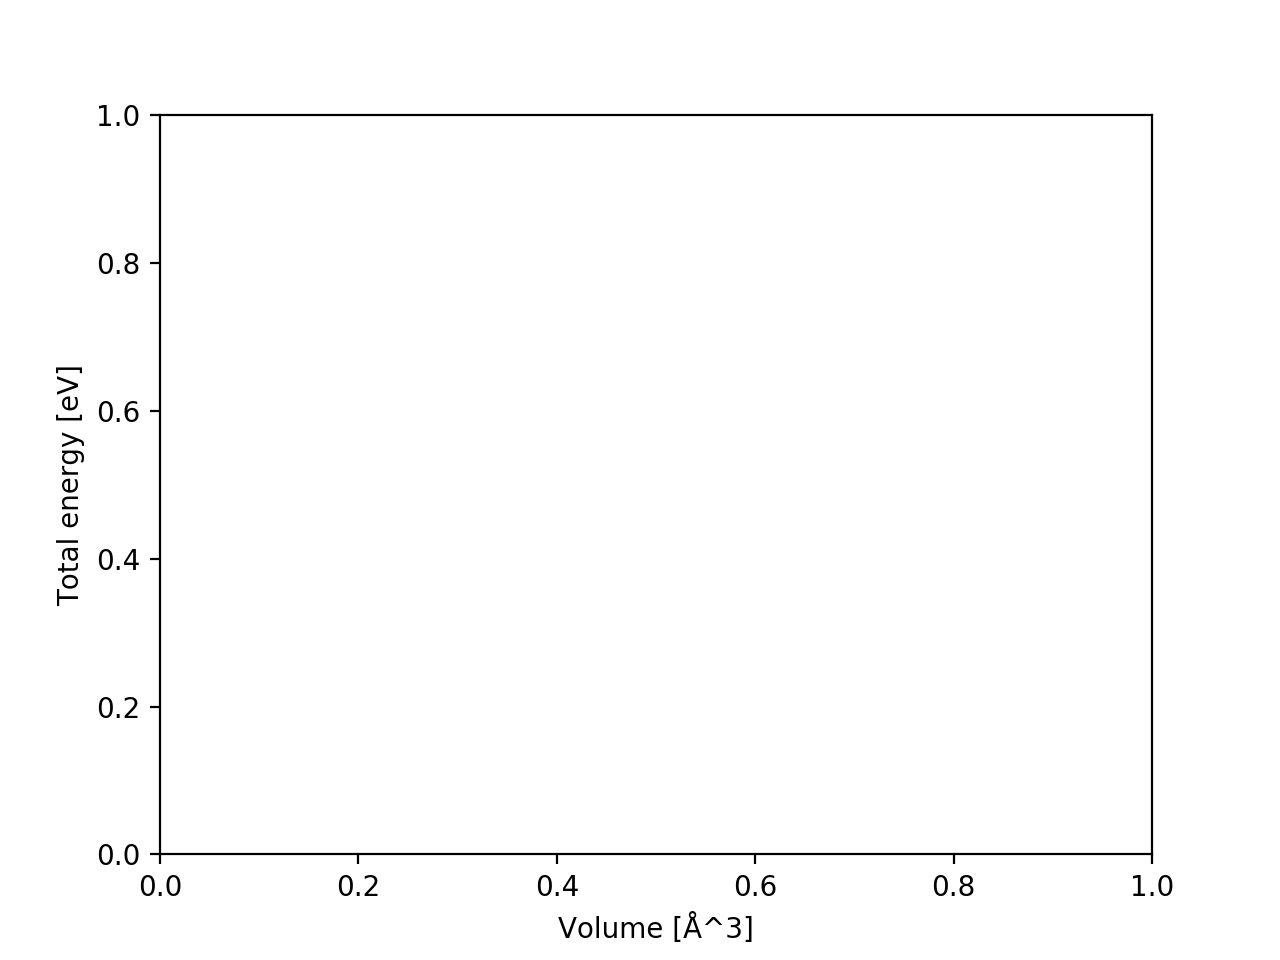

TypeError: Expecting an object of type <class 'aiida.orm.nodes.process.process.ProcessNode'>, got <class 'NoneType'>

In [12]:
opt_submit = SubmitButtonWidget(process=Cp2kCalculation, widgets_values=setup_opt_calc)
opt_submit.on_click(show_eos_inputs)
display(structure_widget)
display(ipw.HBox([code_group, number_of_nodes, ipw.HTML("node(s)"), cpus_per_node, ipw.HTML("CPU each")]))
display(opt_submit)